In [21]:
# !pip install transformers

     ---------------------------------------- 5.3/5.3 MB 1.9 MB/s eta 0:00:00
     -------------------------------------- 163.5/163.5 kB 3.3 MB/s eta 0:00:00
     ---------------------------------------- 3.3/3.3 MB 1.9 MB/s eta 0:00:00


In [18]:
import nltk


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import torch
from torch.nn import CrossEntropyLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm, trange
from ast import literal_eval
import re
import string
import sys
import argparse
from nltk.tokenize import word_tokenize


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 SUPER'

In [3]:
model_path='C:\\Users\\cccc\\TextClassıfıcatıon\\HARD_best_weights.pt'

# Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [4]:
arab_df = pd.read_csv('balanced-reviews.tsv', delimiter='\t')
arab_df.head(10)

,no,Hotel name,rating,user type,room type,nights,review
0,2,فندق 72,2,مسافر منفرد,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“ممتاز”. النظافة والطاقم متعاون.
1,3,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,16,فندق 72,5,زوج,-,أقمت ليلتين,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,20,فندق 72,1,زوج,غرفة قياسية مزدوجة,أقمت ليلة واحدة,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,23,فندق 72,4,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...
5,24,فندق 72,5,أسرة,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,ممتاز. موقع الفندق ونظافته والاطلاله على البحر...
6,25,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,“جيدجداً”. الافطار جيد والسرير ممتاز ومريح واط...
7,26,فندق 72,5,مسافر منفرد,-,أقمت ليلتين,“فندق ممتاز”. الاثاث، النظافه.
8,27,فندق 72,5,أسرة,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلتين,“الراحة و الهدوء”. مكان مناسب ومريح انصح به خ...
9,28,فندق 72,5,زوج,غرفة ديلوكس مزدوجة أو توأم,أقمت ليلة واحدة,استثنائي. المكان روعه تحديدا الغرف المطله على ...


In [5]:
arab_df = arab_df[['rating', 'review']] # we are interested in rating and review only
# code rating as +ve if > 3, -ve if less, no 3s in dataset 
arab_df['rating'] = arab_df['rating'].apply(lambda x: 0 if x < 3 else 1)
# rename columns to fit default constructor in fastai
arab_df.columns = ['label', 'text']
arab_df.head()

,label,text
0,0,“ممتاز”. النظافة والطاقم متعاون.
1,1,استثنائي. سهولة إنهاء المعاملة في الاستقبال. ل...
2,1,استثنائي. انصح بأختيار الاسويت و بالاخص غرفه ر...
3,0,“استغرب تقييم الفندق كخمس نجوم”. لا شي. يستحق ...
4,1,جيد. المكان جميل وهاديء. كل شي جيد ونظيف بس كا...


In [6]:
print('Null values: ', arab_df.isnull().values.any())

Null values:  False


In [7]:
#checking if the dataset is balanced or not
arab_df['label'].value_counts()

0    52849
1    52849
Name: label, dtype: int64

In [8]:
#checking if there is any duplicated data
arab_df.duplicated().sum()

1654

In [9]:
#dropping duplicated values 
arab_df.drop_duplicates(
    subset=None, 
    keep='first', 
    inplace=True, 
    ignore_index=True
    )

In [25]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ '''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_diacritics(text):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', str(text))
    return text

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text
def clean_text(text):
    text = re.sub('[‘’“”…]', '', str(text))
    text = "".join([word for word in text if word not in string.punctuation])
    text = remove_emoji(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens])
    return text

In [26]:
# splitting data into training and testing
from sklearn.model_selection import train_test_split
ara_train, ara_test = train_test_split(arab_df, test_size=0.20)

In [24]:
# nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cccc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [27]:
ara_train['cleanedtext'] = ara_train.text.apply(lambda x: clean_text(x))
ara_test['cleanedtext'] = ara_test.text.apply(lambda x: clean_text(x))

#setting the training data
labels = list(ara_train.label.values)
reviews = list(ara_train.cleanedtext.values)

#setting the testting data
test_labels = list(ara_test.label.values)
test_reviews = list(ara_test.cleanedtext.values)

In [28]:
print('average train sentence length: ', ara_train['cleanedtext'].str.split().str.len().mean())
print('stdev train sentence length: ', ara_train['cleanedtext'].str.split().str.len().std())

average train sentence length:  23.776524298672435
stdev train sentence length:  24.329313940960457


In [29]:
print('average test sentence length: ', ara_test['cleanedtext'].str.split().str.len().mean())
print('stdev test sentence length: ', ara_test['cleanedtext'].str.split().str.len().std())

average test sentence length:  23.697006103128455
stdev test sentence length:  24.471268356679495


# Choosing Sequence Length

BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review:

In [30]:
ara_train['text_len'] = ara_train.loc[:,'text'].apply(lambda x:len(x.split()))

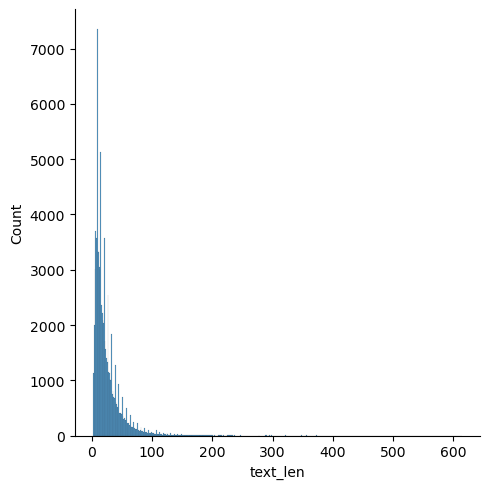

In [31]:
import seaborn as sb
sb.displot(ara_train.text_len,bins=512)

In [32]:
max_length = 60
ara_train = ara_train.reset_index(drop=True)
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 32
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic") # tokenizer
encodings = tokenizer.batch_encode_plus(reviews,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Downloading:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

C:\Users\cccc\anaconda3\envs\demo\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\cccc\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/334k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\cccc\anaconda3\envs\demo\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [33]:
encodings = tokenizer.batch_encode_plus(reviews,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [34]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [35]:
train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.10)

In [36]:
# converting all numpy arrays to tensors
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

In [37]:
# creating data loader and loading data into it using random sampler
train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [38]:
# saving data loaders
torch.save(validation_dataloader,'validation_HARDdata_loader')
torch.save(train_dataloader,'train_HARDdata_loader')

In [ ]:
#device =  torch.device('cpu')

In [42]:
# loading pretrained BERT model
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = AutoModel.from_pretrained("asafaya/bert-base-arabic", return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 2)
    
    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at asafaya/bert-base-arabic were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [43]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [44]:
# initialising optimizer
from torch.optim import AdamW
optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5)

In [45]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=3, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [46]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=5, path=model_path, verbose=True)

# Training and Validation

In [80]:
val_acc_list = []
# Store our loss and accuracy for plotting
train_loss_set = []
valid_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs =50

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # set model to training mode 
    model.train()
    
    # Tracking variables of traning
    tr_loss = 0 #running loss
    nb_tr_examples, nb_tr_steps = 0, 0
    
     # Tracking variables of validation
    vl_loss = 0 #running loss
    nb_vl_examples, nb_vl_steps = 0, 0

    # train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        # unpack the inputs from dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        # clearing the gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(b_input_ids, b_input_mask ,b_token_types)
        logits = outputs
        loss_func = CrossEntropyLoss()
        # converting logits and labels to appropriate shape 
        loss = loss_func(logits,b_labels) 
        train_loss_set.append(loss.item())    


        # backward pass
        loss.backward()
        # update parameters and take a step using the computed gradient
        optimizer.step()
        
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))

    #################################################################
    #validation 
    
    # set model to evaluation mode
    model.eval()
    
    # variables to gather outputs
    logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]


    # predict
    for i, batch in enumerate(validation_dataloader):
        batch = tuple(t.to(device) for t in batch) 
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels, b_token_types = batch
        with torch.no_grad():
            # forward pass
            outs = model(b_input_ids, b_input_mask ,b_token_types)
            # Calculate Validation Loss
            logits_val = outs
            
            loss_func_val = CrossEntropyLoss() 
            loss_val = loss_func_val(logits_val,b_labels) 
            valid_loss_set.append(loss_val.item())
            
            vl_loss += loss_val.item()
            nb_vl_examples += b_input_ids.size(0)
            nb_vl_steps += 1

            b_logit_pred = outs
            pred_label = torch.argmax(b_logit_pred, dim=1)

            # converting tensors to numpy arrays
            b_logit_pred = b_logit_pred.detach().cpu()
            pred_label = pred_label.to('cpu')
            b_labels = b_labels.to('cpu')
            
        tokenized_texts.append(b_input_ids)
        logit_preds.append(b_logit_pred)
        true_labels.append(b_labels)
        pred_labels.append(pred_label)
        
    print("Validation loss: {}".format(vl_loss/nb_vl_steps))
    
    # flatten outputs
    pred_labels = [item for sublist in pred_labels for item in sublist]
    true_labels = [item for sublist in true_labels for item in sublist]
    
#     Calculate Accuracy
#     threshold = 0.50
#     pred_bools = [pl>threshold for pl in pred_labels]
    val_f1_accuracy = f1_score(true_labels,pred_labels,average='micro')*100
    val_flat_accuracy = accuracy_score(true_labels, pred_labels)*100   
        

    print('F1 Validation Accuracy: ', val_f1_accuracy)
    print('Flat Validation Accuracy: ', val_flat_accuracy)
    
    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(vl_loss/nb_vl_steps, model)

    if early_stopping.early_stop:
        print("Early stopping")
        break

Epoch:   0%|                                                                                    | 0/50 [00:00<?, ?it/s]

Train loss: 0.009801963859604966
Validation loss: 0.296794252874941
F1 Validation Accuracy:  95.1826045170591
Flat Validation Accuracy:  95.1826045170591
Validation loss decreased (inf --> 0.296794).  Saving model ...


Epoch:   2%|█▍                                                                      | 1/50 [16:16<13:17:39, 976.72s/it]

Train loss: 0.010049022582502967
Validation loss: 0.29104472082852023
F1 Validation Accuracy:  95.03844305622296
Flat Validation Accuracy:  95.03844305622296
Validation loss decreased (0.296794 --> 0.291045).  Saving model ...


Epoch:   4%|██▉                                                                     | 2/50 [32:33<13:01:24, 976.76s/it]

Train loss: 0.00840148954262164
Validation loss: 0.3193050138929424


Epoch:   6%|████▎                                                                   | 3/50 [48:49<12:44:49, 976.36s/it]

F1 Validation Accuracy:  94.72609322441133
Flat Validation Accuracy:  94.72609322441134
EarlyStopping counter: 1 out of 5
Train loss: 0.008458583957855785
Validation loss: 0.3377506749450128


Epoch:   8%|█████▌                                                                | 4/50 [1:05:02<12:27:37, 975.15s/it]

F1 Validation Accuracy:  94.79817395482941
Flat Validation Accuracy:  94.79817395482941
EarlyStopping counter: 2 out of 5
Train loss: 0.007848009761237111
Validation loss: 0.304607739090713


Epoch:  10%|███████                                                               | 5/50 [1:21:15<12:10:47, 974.39s/it]

F1 Validation Accuracy:  94.72609322441133
Flat Validation Accuracy:  94.72609322441134
EarlyStopping counter: 3 out of 5
Train loss: 0.006698804640146598
Validation loss: 0.32149268941507964


Epoch:  12%|████████▍                                                             | 6/50 [1:37:28<11:54:06, 973.79s/it]

F1 Validation Accuracy:  94.99038923594426
Flat Validation Accuracy:  94.99038923594426
EarlyStopping counter: 4 out of 5
Train loss: 0.007795440891264341
Validation loss: 0.33370966846430544


Epoch:  12%|████████▎                                                            | 6/50 [1:53:43<13:53:57, 1137.22s/it]

F1 Validation Accuracy:  94.93032196059586
Flat Validation Accuracy:  94.93032196059586
EarlyStopping counter: 5 out of 5
Early stopping


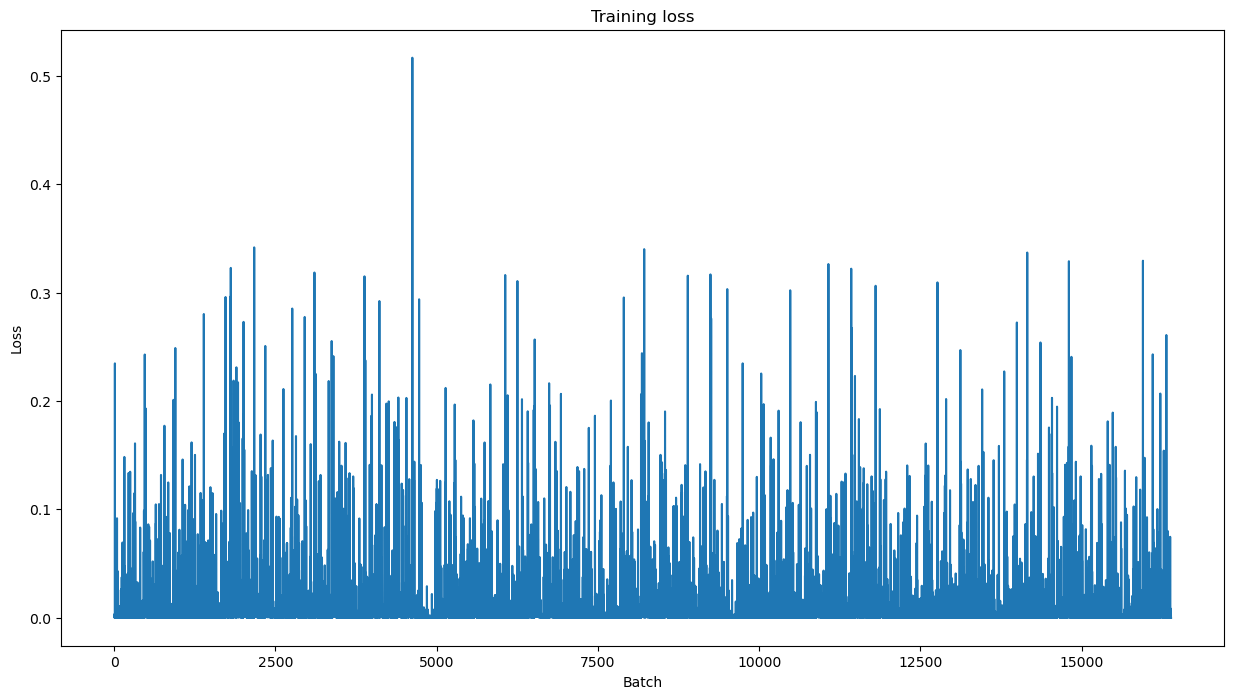

In [84]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

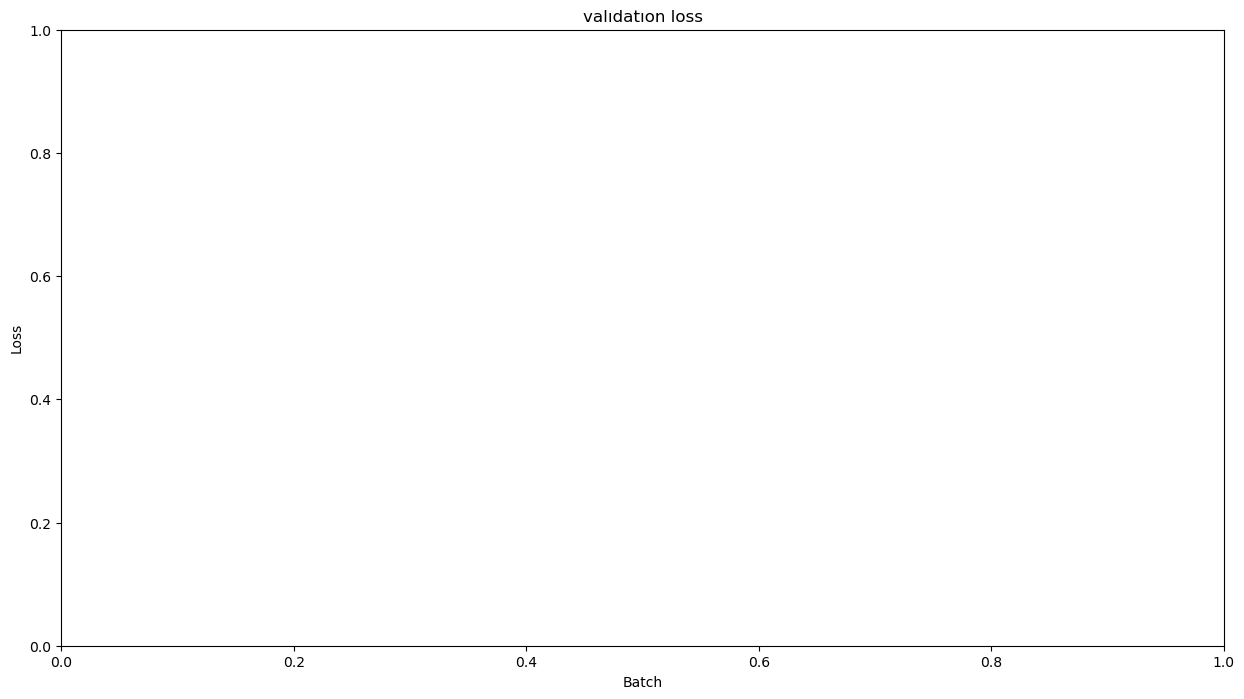

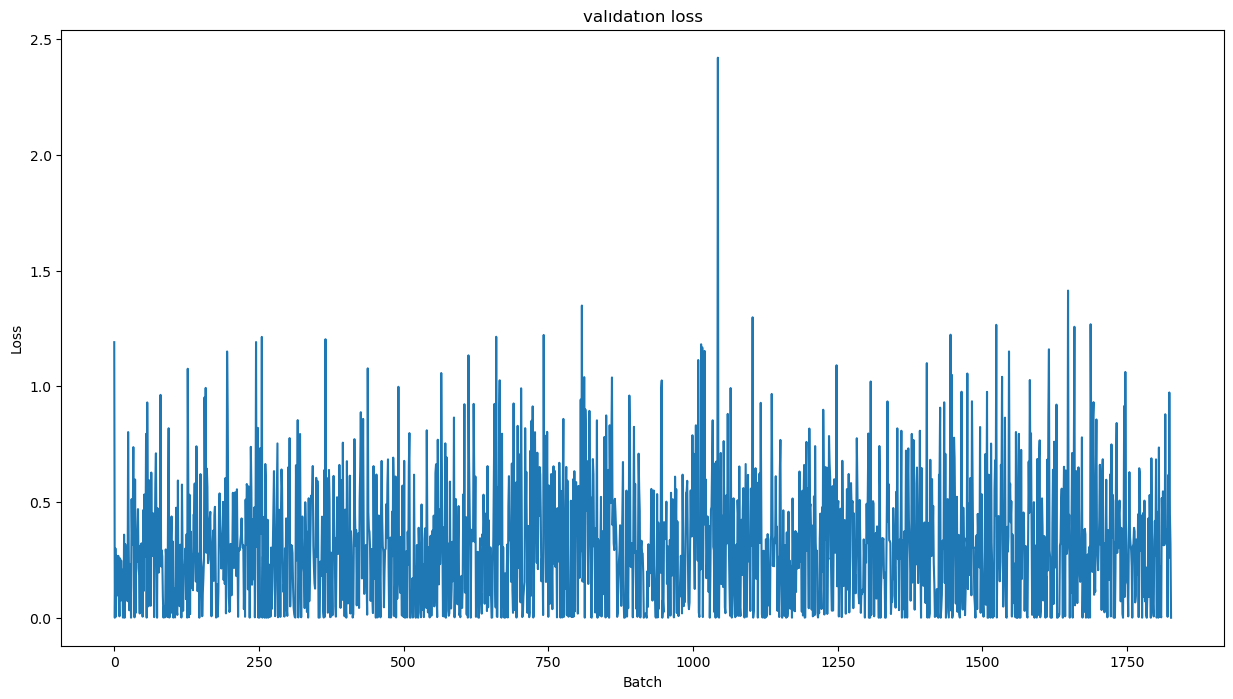

In [86]:
plt.figure(figsize=(15,8))
plt.title("valıdatıon loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(valid_loss_set)
plt.show()

# Save The Model 

In [87]:
# Saving the model for future runs
import pickle
with open('model_pickle','wb') as file:
    pickle.dump(model,file)

In [88]:
# load the last checkpoint with the best model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [89]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(test_reviews,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

C:\Users\cccc\anaconda3\envs\demo\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [90]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [125]:
# testing 

# put model in evaluation mode 
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from test dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
        # forward pass
        outs = model(b_input_ids, b_input_mask ,b_token_types)
        b_logit_pred = outs
#         pred_label = torch.sigmoid(b_logit_pred)
#         # Apply softmax to calculate probabilities
        pred_label = torch.argmax(b_logit_pred, dim=1)
        b_logit_pred = F.softmax(b_logit_pred)

        # converting into numpy arrays 
        b_logit_pred = b_logit_pred.detach().cpu()
        pred_label = pred_label.to('cpu')
        b_labels = b_labels.to('cpu')
        
    # appending output variables 
    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    pred_labels.append(pred_label)  
    true_labels.append(b_labels) 
    
# flatten output variables
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
 
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

C:\Users\cccc\AppData\Local\Temp\ipykernel_13568\3278113523.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  b_logit_pred = F.softmax(b_logit_pred)


In [126]:
# pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_labels, pred_labels,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_labels, pred_labels),'\n')
clf_report = classification_report(true_labels,pred_labels,target_names=['posıtıve', 'negatıve'])
pickle.dump(clf_report, open('HARD_Arabic_classification_report.txt','wb'))
print(clf_report)

Test F1 Accuracy:  0.9498774568696238
Test Flat Accuracy:  0.9498774568696238 

              precision    recall  f1-score   support

    posıtıve       0.96      0.94      0.95     10376
    negatıve       0.94      0.96      0.95     10433

    accuracy                           0.95     20809
   macro avg       0.95      0.95      0.95     20809
weighted avg       0.95      0.95      0.95     20809



In [127]:
# Calculate Accuracy - maximize F1 accuracy by tuning threshold values. First with 'macro_thresholds' on the order of e^-1 then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_macro_th = macro_thresholds[np.argmax(f1_results)] #best macro threshold value

micro_thresholds = (np.array(range(10))/100)+best_macro_th #calculating micro threshold values

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
    pred_bools = [pl>th for pl in pred_labels]
    test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
    test_flat_accuracy = accuracy_score(true_bools, pred_bools)
    f1_results.append(test_f1_accuracy)
    flat_acc_results.append(test_flat_accuracy)

best_f1_idx = np.argmax(f1_results) #best threshold value

# Printing and saving classification report
print('Best Threshold: ', micro_thresholds[best_f1_idx])
print('Test F1 Accuracy: ', f1_results[best_f1_idx])
print('Test Flat Accuracy: ', flat_acc_results[best_f1_idx], '\n')

best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
clf_report_optimized = classification_report(true_bools,best_pred_bools, target_names=['posıtıve', 'negatıve'])
pickle.dump(clf_report_optimized, open('HARD_Arabic_classification_report_optimized.txt','wb'))
print(clf_report_optimized)

Best Threshold:  0.1
Test F1 Accuracy:  0.9498774568696238
Test Flat Accuracy:  0.9498774568696238 

              precision    recall  f1-score   support

    posıtıve       0.96      0.94      0.95     10376
    negatıve       0.94      0.96      0.95     10433

    accuracy                           0.95     20809
   macro avg       0.95      0.95      0.95     20809
weighted avg       0.95      0.95      0.95     20809



In [122]:
import seaborn as sns
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(true_labels, pred_labels)
show_confusion_matrix(df_cm)


# Arabic_Reviews_Prediction

# Load and Preprocess Training Data

In [129]:
file1 = 'AR_HOTE_SB1_TEST.xml.csv'
file2 = 'AR_HOTE_SB2_TEST.xml.csv'
file3 = 'AR_Hotels_Train_SB1.xml.csv'
file4 = 'AR_Hotels_Train_SB2.xml.csv'

In [130]:
print("Merging multiple CSV files...")

# merge
ara_test = pd.concat(
   map(pd.read_csv, [file1, file2, file3, file4]), ignore_index=True)

Merging multiple CSV files...


In [131]:
ara_test.head()

,Unnamed: 0,rid,polarity,category,sentence
0,0,NaN,NaN,NaN,NaN
1,1,287.0,negative,ROOMS_AMENITIES#GENERAL,['كانت رحلتي لهذا المرفق موفقه ، لكن كانت بعض ...
2,2,287.0,positive,FACILITIES#GENERAL,['كانت رحلتي لهذا المرفق موفقه ، لكن كانت بعض ...
3,3,1039.0,negative,ROOMS_AMENITIES#GENERAL,['رضى النزيل الاجهزة الكهربائية غير سليمة الشا...
4,4,1039.0,negative,ROOMS_AMENITIES#GENERAL,['رضى النزيل الاجهزة الكهربائية غير سليمة الشا...


In [132]:
ara_test['polarity'].value_counts()

positive    14002
negative     8407
neutral      1495
conflict      124
Name: polarity, dtype: int64

In [133]:
# exclude the neutral and cnoflıct from the dataset because of our model traıned on just two polarıtıes posıtıve and negatıve
ara_test.drop(ara_test[(ara_test['polarity'] =='conflict') | (ara_test['polarity'] =='neutral')].index, inplace=True)

In [134]:
ara_test['polarity'].value_counts()

positive    14002
negative     8407
Name: polarity, dtype: int64

In [135]:
df_test = ara_test[['polarity', 'sentence']] # we are interested in rating and review only
# code rating as +ve if > 3, -ve if less, no 3s in dataset 
df_test['polarity'] = ara_test['polarity'].apply(lambda x: 0 if x == 'negative' else 1)
# rename columns to fit default constructor in fastai
df_test.columns = ['label', 'review']
df_test.head()

C:\Users\cccc\AppData\Local\Temp\ipykernel_13568\612961551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['polarity'] = ara_test['polarity'].apply(lambda x: 0 if x == 'negative' else 1)


,label,review
0,1,NaN
1,0,['كانت رحلتي لهذا المرفق موفقه ، لكن كانت بعض ...
2,1,['كانت رحلتي لهذا المرفق موفقه ، لكن كانت بعض ...
3,0,['رضى النزيل الاجهزة الكهربائية غير سليمة الشا...
4,0,['رضى النزيل الاجهزة الكهربائية غير سليمة الشا...


In [136]:
# check ıf there ıs any null values
df_test.isnull().sum()

label     0
review    4
dtype: int64

In [137]:
# dropping the null values
df_test.dropna(inplace=True)

C:\Users\cccc\AppData\Local\Temp\ipykernel_13568\1781431545.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.dropna(inplace=True)


In [138]:
df_test['label'].value_counts()

1    14002
0     8407
Name: label, dtype: int64

In [139]:
# check ıf there ıs any duplıcated values
df_test.duplicated().sum()

19450

In [140]:
# droppıng the duplıcated values
df_test.drop_duplicates(subset=['review'],keep='first',inplace=True,ignore_index=True)
df_test.head()

C:\Users\cccc\AppData\Local\Temp\ipykernel_13568\1780530119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop_duplicates(subset=['review'],keep='first',inplace=True,ignore_index=True)


,label,review
0,0,['كانت رحلتي لهذا المرفق موفقه ، لكن كانت بعض ...
1,0,['رضى النزيل الاجهزة الكهربائية غير سليمة الشا...
2,1,['انها زيارتى الرابعة الغرفة ممتازة كانت بالدو...
3,0,['الطعام بارد، فريق العمل غير متمرس، المديرون ...
4,1,['خدمات مريحة هذا الفندق من الفنادق المميزة فى...


In [141]:
# as we can see the dataset ıs unbalanced
df_test['label'].value_counts()

1    1555
0     734
Name: label, dtype: int64

In [142]:
# to make dataset ıs balanced we wıll use Undersampling method
# Class count
count_class_1, count_class_0 = df_test.label.value_counts()

# Divide by class
df_class_0 = df_test[df_test['label'] == 0]
df_class_1 = df_test[df_test['label'] == 1]

In [143]:
# Undersample 1-class and concat the DataFrames of both class
df_class_1_under = df_class_1.sample(count_class_0)
df_test_balanced = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_balanced.label.value_counts())

Random under-sampling:
1    734
0    734
Name: label, dtype: int64


In [144]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ $'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

def remove_diacritics(text):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(arabic_diacritics, '', str(text))
    return text

def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    return text
def clean_text(text):
    text = re.sub('[‘’“”…]', '', str(text))
    text = "".join([word for word in text if word not in string.punctuation])
    text = remove_emoji(text)
    text = normalize_arabic(text)
    text = remove_diacritics(text)
    tokens = word_tokenize(text)
    text = ' '.join([word for word in tokens])
    return text

In [145]:
df_test_balanced['cleanedtext'] = df_test_balanced.review.apply(lambda x: clean_text(x))
df_test_balanced['cleanedtext'] = df_test_balanced['cleanedtext'].astype(str)
#setting the training data
labels = list(df_test_balanced.label.values)
reviews = list(df_test_balanced.cleanedtext.values)

In [146]:
print('average train sentence length: ', df_test_balanced['cleanedtext'].str.split().str.len().mean())
print('stdev train sentence length: ', df_test_balanced['cleanedtext'].str.split().str.len().std())

average train sentence length:  54.02179836512261
stdev train sentence length:  13.662433941084203


In [147]:
max_length = 100
df_test_balanced = df_test_balanced.reset_index(drop=True)
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic") # tokenizer
encodings = tokenizer.batch_encode_plus(reviews,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method
print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\cccc\anaconda3\envs\demo\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [148]:
# Encoding input data
test_encodings = tokenizer.batch_encode_plus(reviews,max_length=max_length,pad_to_max_length=True)
test_input_ids = test_encodings['input_ids']
test_token_type_ids = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

In [149]:
# Make tensors out of data
test_inputs = torch.tensor(test_input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)
# Create test dataloader
test_data = TensorDataset(test_inputs, test_masks, test_labels, test_token_types)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Load Saved Model

In [150]:
with open('model_pickle','rb') as file:
    bert_model = pickle.load(file)

In [151]:
# testing 

# put model in evaluation mode 
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts  = [],[],[],[]

# predict
# reading input from each batch
for i, batch in enumerate(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # unpack the inputs from test dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
        # forward pass
        outs = bert_model(b_input_ids, b_input_mask ,b_token_types)
        b_logit_pred = outs
#         pred_label = torch.sigmoid(b_logit_pred)
#         # Apply softmax to calculate probabilities
        pred_label = torch.argmax(b_logit_pred, dim=1)
        b_logit_pred = F.softmax(b_logit_pred)

        # converting into numpy arrays 
        b_logit_pred = b_logit_pred.detach().cpu()
        pred_label = pred_label.to('cpu')
        b_labels = b_labels.to('cpu')
        
    # appending output variables 
    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    pred_labels.append(pred_label)  
    true_labels.append(b_labels) 
    
# flatten output variables
tokenized_texts = [item for sublist in tokenized_texts for item in sublist]
pred_labels = [item for sublist in pred_labels for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]
 
# Converting flattened binary values to boolean values
true_bools = [tl==1 for tl in true_labels]

C:\Users\cccc\AppData\Local\Temp\ipykernel_13568\3379750798.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  b_logit_pred = F.softmax(b_logit_pred)


In [152]:
# pred_bools = [pl>0.50 for pl in pred_labels] #boolean output after thresholding

# Print and save classification report
print('Test F1 Accuracy: ', f1_score(true_labels, pred_labels,average='micro'))
print('Test Flat Accuracy: ', accuracy_score(true_labels, pred_labels),'\n')
clf_report = classification_report(true_labels,pred_labels,target_names=['posıtıve', 'negatıve'])
pickle.dump(clf_report, open('HARD_Arabic_classification_report.txt','wb'))
print(clf_report)

Test F1 Accuracy:  0.9100817438692099
Test Flat Accuracy:  0.9100817438692098 

              precision    recall  f1-score   support

    posıtıve       0.90      0.92      0.91       734
    negatıve       0.92      0.90      0.91       734

    accuracy                           0.91      1468
   macro avg       0.91      0.91      0.91      1468
weighted avg       0.91      0.91      0.91      1468

